## Многомерная линейная регрессия

До этого мы рассматривали только один признак - среднее число комнат на участке. Давайте в нашу модель добавим еще один признак - процент жителей с низким социальным статусом (`LSTAT`).

In [ ]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn")

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

In [ ]:
from sklearn.datasets import load_boston
boston = load_boston()

In [ ]:
data = pd.DataFrame(data=boston.data, columns=boston.feature_names)
data["MEDV"] = boston.target
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


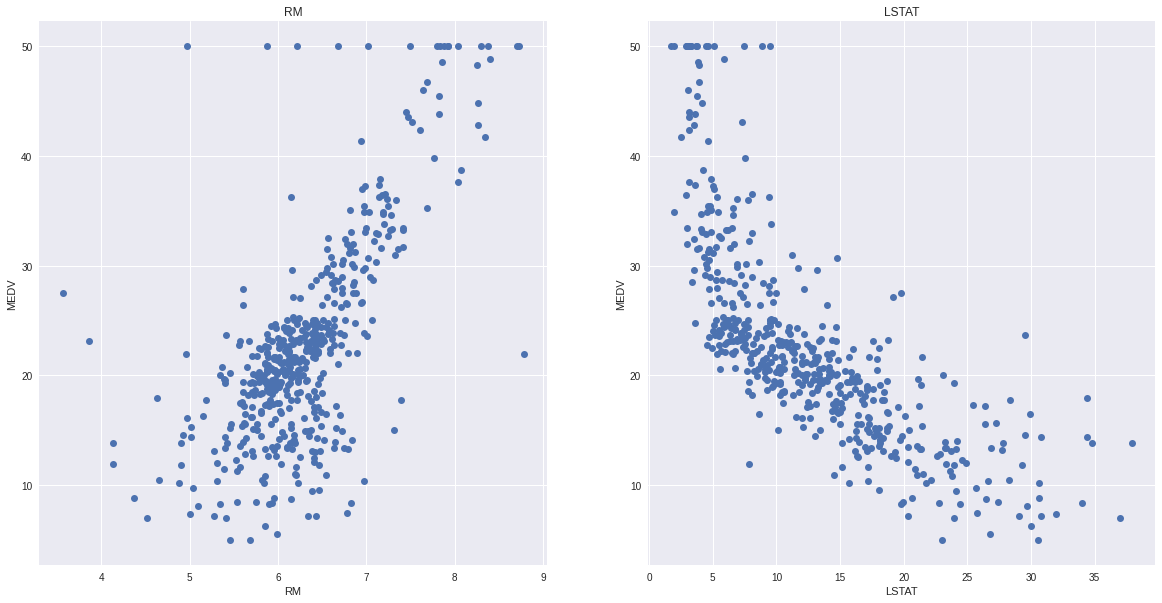

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 10))
for i, col in enumerate(["RM", "LSTAT"]):
    plt.subplot(1, 2, (i+1))
    plt.plot(data[col], data["MEDV"], 'o')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('MEDV')

In [ ]:
X_filtered = data[(data["MEDV"] < 50)][["RM", "LSTAT"]]
y_filtered = data[(data["MEDV"] < 50)]["MEDV"]

In [ ]:
def z_scaler(feature):
    return (feature - np.mean(feature)) / np.std(feature)

In [ ]:
X_scaled = z_scaler(X_filtered)
y_scaled = z_scaler(y_filtered)

In [ ]:
class GDRegressor:

    def __init__(self, alpha=0.01, n_iter=100, progress=True):
        self.alpha = alpha
        self.n_iter = n_iter
        self.disable = not progress

    def fit(self, X, y):
        X = np.c_[np.ones((len(X), 1)), X] # Add a column of ones to x
        self.theta = np.zeros(X.shape[1]) # initialize fitting parameters
        self.loss = self.computeCost(X, y) # compute initial cost
        self.theta = self.gradientDescent(X, y) # find final parameters
        print(self.computeCost(X, y)) # compute and display final cost
        self.intercept_ = self.theta[0]
        self.coef_ = self.theta[1:]
        
    def predict(self, X_test):
        X_test = np.c_[np.ones((len(X_test), 1)), X_test] # Add a column of ones to x
        return X_test @ self.theta

    def computeCost(self, X, y):
        return np.square(np.mean(X @ self.theta - y)) / 2

    def gradientDescent(self, X, y):
        self.loss_history = self.loss
        self.theta_history = self.theta
        for _ in tqdm(np.arange(self.n_iter), disable=self.disable): # run gradient descent
          self.theta -= self.alpha * (X @ self.theta - y) @ X / len(X)
          self.theta_history = np.vstack([self.theta_history, self.theta])
          self.loss = self.computeCost(X, y)
          self.loss_history = np.hstack([self.loss_history, self.loss])
        return self.theta

In [ ]:
X_train, X_test, Y_train, Y_test =\
    train_test_split(X_scaled, y_scaled, test_size=0.33, random_state=18)
model = GDRegressor(alpha=0.01, n_iter=300)
%time model.fit(X_train, Y_train)
model.coef_, model.intercept_


1.158516581684042e-06
CPU times: user 294 ms, sys: 8.73 ms, total: 303 ms
Wall time: 330 ms


(array([ 0.35397552, -0.52649765]), -0.03142180507283753)

In [ ]:
def plot_loss_function(model):
    plt.xlabel("Iterations")
    plt.ylabel("Average square loss")
    plt.plot(np.arange(model.n_iter + 1), model.loss_history)

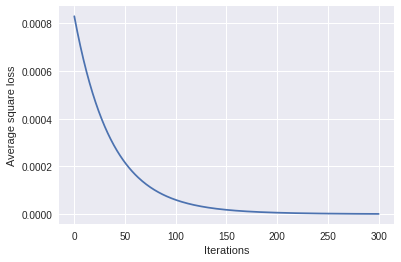

In [ ]:
plot_loss_function(model)

In [ ]:
Y_pred = model.predict(X_test)
mean_squared_error(Y_test, Y_pred), r2_score(Y_test, Y_pred)

(0.3488356401772447, 0.6983961377962583)

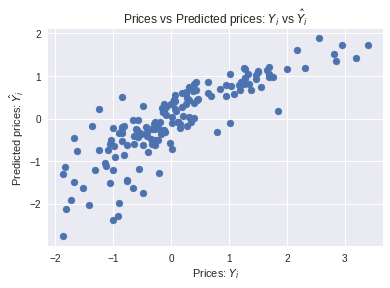

In [ ]:
plt.scatter(Y_test, Y_pred)
plt.xlabel("Prices: $Y_i$")
plt.ylabel("Predicted prices: $\hat{Y}_i$")
plt.title("Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$");

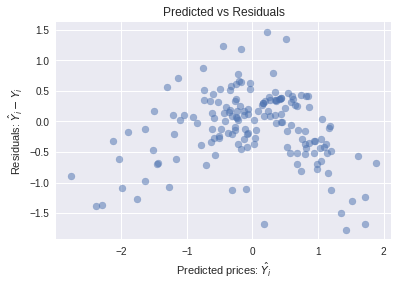

In [ ]:
plt.xlabel("Predicted prices: $\hat{Y}_i$")
plt.ylabel("Residuals: $\hat{Y}_i - Y_i$")
plt.title("Predicted vs Residuals");'''  '''
plt.scatter(Y_pred, (Y_pred - Y_test.ravel()), alpha=0.5);

Из графика хорошо видно, что есть нелинейная зависимость в остатках. Это 
связано с тем, что процент жителей с низким социальным статусом нелинейно 
зависит от средней цены на дом и среднего числа комнат:

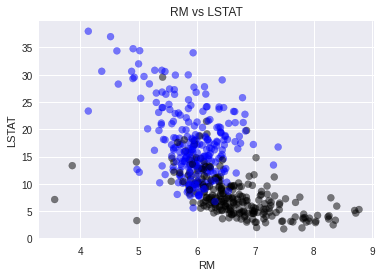

In [ ]:
colors = ['k' if v > data["MEDV"].median() else 'b' for v in data["MEDV"]]
plt.scatter(data["RM"], data["LSTAT"], c=colors, alpha=0.5)
plt.xlabel("RM");
plt.ylabel("LSTAT");
plt.title("RM vs LSTAT")
plt.show()

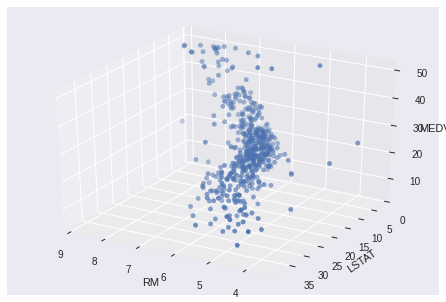

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure() # figsize=(15, 10))
ax = Axes3D(fig)
ax.set_xlabel('RM')
ax.set_ylabel('LSTAT')
ax.set_zlabel('MEDV');
ax.view_init(azim=120)
ax.scatter3D(data["RM"], data["LSTAT"], data["MEDV"])
plt.show()

Эту зависимость наша модель в настоящий момент не описывает. Таким образом, мы должны добавить в нашу модель нелинейные признаки.

### Добавление полиномиальных признаков

Итак, для описания нелинейной зависимости мы будем использовать полиномиальную модель. Предположим, что полинома четвертой степени достаточно для описания зависимости. Возможно будет достаточно полинома второй или третьей степени, поэтому, чтобы «занулить» некоторые коэффициенты $\theta$, мы будем использовать L1-регуляризацию.

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
poly = PolynomialFeatures(4, include_bias=False)
X_filtered_poly = poly.fit_transform(X_filtered)

In [ ]:
X_train, X_test, Y_train, Y_test =\
    train_test_split(X_filtered_poly, y_filtered, test_size = 0.33, random_state = 18)
x_scaler = StandardScaler()
y_scaler = StandardScaler()
X_train = x_scaler.fit_transform(X_train)
Y_train = y_scaler.fit_transform(Y_train.values.reshape(-1, 1))
X_test = x_scaler.transform(X_test)
Y_test = y_scaler.transform(Y_test.values.reshape(-1, 1))

In [ ]:
model = SGDRegressor(
    loss='squared_loss',
    penalty='l1', #!!
    alpha=0.01, # regularisation parameter #!!
    learning_rate='constant',
    max_iter=1000,
    eta0=0.005 # Learning rate
)
model.fit(X_train, Y_train.ravel())

SGDRegressor(alpha=0.01, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.005, fit_intercept=True, l1_ratio=0.15,
             learning_rate='constant', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l1', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [ ]:
Y_pred = model.predict(X_test)
mean_squared_error(Y_test, Y_pred), r2_score(Y_test, Y_pred)

(0.24520400451992172, 0.8054579269371747)

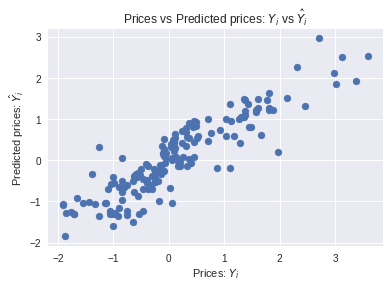

In [ ]:
plt.scatter(Y_test, Y_pred)
plt.xlabel("Prices: $Y_i$")
plt.ylabel("Predicted prices: $\hat{Y}_i$")
plt.title("Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$");

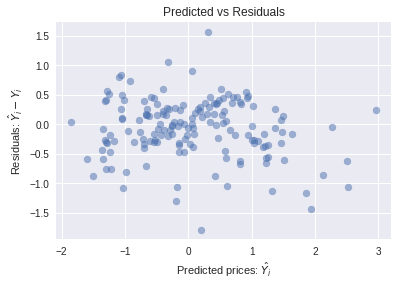

In [ ]:
fig = plt.figure()
plt.scatter(Y_pred, (Y_pred-Y_test.reshape(1, -1)), alpha=0.5);
plt.xlabel("Predicted prices: $\hat{Y}_i$")
plt.ylabel("Residuals: $\hat{Y}_i - Y_i$")
plt.title("Predicted vs Residuals");
fig.savefig('lr_residuals3.png', dpi=fig.dpi)

In [ ]:
model.coef_, model.intercept_

(array([ 0.        ,  0.        ,  0.07844113, -0.07443951,  0.        ,
         0.19288524, -0.21666298,  0.        ,  0.        ,  0.22452851,
        -0.2958603 ,  0.        ,  0.        ,  0.05685711]),
 array([-0.00457272]))

In [ ]:
poly.get_feature_names(X_filtered.columns)

['RM',
 'LSTAT',
 'RM^2',
 'RM LSTAT',
 'LSTAT^2',
 'RM^3',
 'RM^2 LSTAT',
 'RM LSTAT^2',
 'LSTAT^3',
 'RM^4',
 'RM^3 LSTAT',
 'RM^2 LSTAT^2',
 'RM LSTAT^3',
 'LSTAT^4']

Проверяем нашу модель на работу со множественными полиномиальными фичами:

In [ ]:
model = GDRegressor(alpha=0.04, n_iter=5000)
%time model.fit(X_train, Y_train.ravel())
model.coef_, model.intercept_


6.622174347744332e-35
CPU times: user 730 ms, sys: 30.8 ms, total: 761 ms
Wall time: 807 ms


(array([-0.22540041,  0.15544204,  0.3719951 , -0.06843716,  0.03574962,
         0.4578459 , -0.21059111,  0.0199904 , -0.05940549,  0.04995925,
        -0.3566665 , -0.06807309,  0.01831631,  0.05594983]),
 2.0540977032445265e-15)

In [ ]:
Y_pred = model.predict(X_test)
mean_squared_error(Y_test, Y_pred), r2_score(Y_test, Y_pred)

(0.22235111706815733, 0.8235891483625428)

Что очень близко к показателям линейной модели sklearn или лучше их.


### Задания

- Постройте кривые обучения
- Какие еще признаки, кроме `LSTAT`, могут улучшить нашу модель? Отберите лучшие, ориентируйтесь на кривые обучения, а также проверяйте ваши модели на валидационных данных.
- Добавьте L2 (Lasso) регуляризацию в класс `GDRegressor`

Строим [кривые обучения 2](https://www.dataquest.io/blog/learning-curves-machine-learning/):

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import learning_curve

train_sizes = [1, 50, 100, 200, 300, 404] # 80/20 ratio for train/validation samples

features = ['RM', 'LSTAT']
target = 'MEDV'
train_sizes, train_scores, validation_scores = learning_curve(
estimator = LinearRegression(),
shuffle = True,
X = data[features],
y = data[target], train_sizes = train_sizes, cv = 5,
scoring = 'neg_mean_squared_error')

In [ ]:
print('Training scores:\n\n', train_scores)
print('\n', '-' * 70) # separator to make the output easy to read
print('\nValidation scores:\n\n', validation_scores)

Training scores:

 [[ -0.          -0.          -0.          -0.          -0.        ]
 [-47.70047818 -30.39024484 -24.95922623 -11.15739151 -19.0214736 ]
 [-36.71735265 -27.84976857 -16.76230116 -13.63267681 -16.41844227]
 [-38.59349131 -25.57734335 -23.25802978 -20.86323312 -25.02311067]
 [-36.2708886  -25.36012888 -32.31108127 -23.01878384 -28.70422863]
 [-35.5401817  -31.34229888 -29.21018362 -21.81055508 -30.21792647]]

 ----------------------------------------------------------------------

Validation scores:

 [[ -55.70421569 -100.51217822 -190.44118812 -111.11445545  -53.62831683]
 [ -25.09013451  -44.62381472  -67.51859615  -47.34170097  -36.17028063]
 [ -18.67603185  -25.36714799  -68.99655912  -57.28375422  -45.52516887]
 [ -14.15571323  -26.41891311  -54.18477708  -65.08700339  -38.81997252]
 [ -13.52105881  -25.7981476   -55.01962128  -68.122282    -40.27835313]
 [ -11.78879381  -29.07378626  -47.83488343  -71.27472677  -36.53141369]]


In [ ]:
train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)
print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_sizes))
print('\n', '-' * 20) # separator
print('\nMean validation scores\n\n',pd.Series(validation_scores_mean, index = train_sizes))

Mean training scores

 1      -0.000000
50     26.645763
100    22.276108
200    26.663042
300    29.133022
404    29.624229
dtype: float64

 --------------------

Mean validation scores

 1      102.280071
50      44.148905
100     43.169732
200     39.733276
300     40.547893
404     39.300721
dtype: float64


(0.0, 100.0)

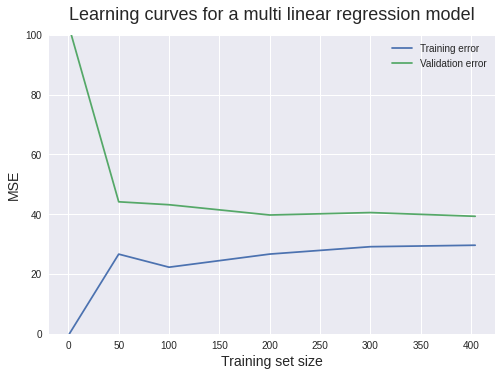

In [ ]:
plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a multi linear regression model', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim(0,100)

Добавим ещё две фичи, хорошо коррелированных с MEDV -- это PTRATIO и INDUS.

In [ ]:
features = ['RM', 'LSTAT', 'PTRATIO', 'INDUS']
target = 'MEDV'
train_sizes, train_scores, validation_scores = learning_curve(
estimator = LinearRegression(),
shuffle = True,
X = data[features],
y = data[target], train_sizes = train_sizes, cv = 5,
scoring = 'neg_mean_squared_error')

In [ ]:
print('Training scores:\n\n', train_scores)
print('\n', '-' * 70) # separator to make the output easy to read
print('\nValidation scores:\n\n', validation_scores)

Training scores:

 [[ -0.          -0.          -0.          -0.          -0.        ]
 [-20.20698544 -24.41620883 -16.73751857 -22.75873262 -12.27274293]
 [-25.59301669 -23.60260609 -20.74012042 -20.17917783 -18.69122573]
 [-30.88447228 -29.00816155 -27.86971198 -17.35961603 -27.60476435]
 [-30.87262556 -28.31671065 -27.06586267 -18.73990456 -28.51786846]
 [-31.75725285 -27.84763247 -26.83227956 -17.51506789 -27.80908878]]

 ----------------------------------------------------------------------

Validation scores:

 [[ -38.14147059 -100.51217822 -102.22376238  -90.47534653  -87.42831683]
 [  -9.24044771  -38.61072544  -78.62443985  -79.8070106   -49.61348735]
 [  -9.03042612  -29.41748165  -52.28124973  -78.12565373  -28.39716137]
 [ -10.79275663  -28.7987962   -37.82254041  -73.39703572  -33.55532609]
 [ -10.39676924  -26.45778882  -38.24139048  -70.30058623  -28.08477745]
 [  -9.41474444  -27.094392    -36.63586883  -74.66269787  -29.63351619]]


In [ ]:
train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)
print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_sizes))
print('\n', '-' * 20) # separator
print('\nMean validation scores\n\n',pd.Series(validation_scores_mean, index = train_sizes))

Mean training scores

 1      -0.000000
50     19.278438
100    21.761229
200    26.545345
300    26.702594
404    26.352264
dtype: float64

 --------------------

Mean validation scores

 1      83.756215
50     51.179222
100    39.450395
200    36.873291
300    34.696262
404    35.488244
dtype: float64


(0.0, 100.0)

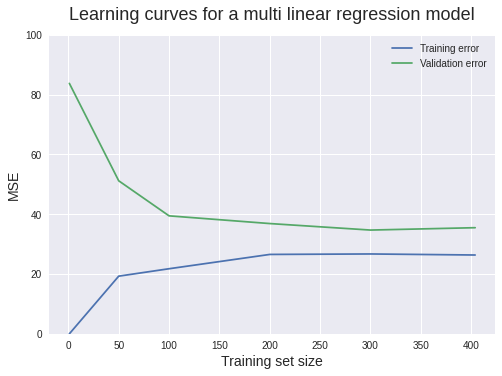

In [ ]:
plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a multi linear regression model', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim(0,100)

Добавляем [Lasso регуляризацию](https://towardsdatascience.com/ridge-and-lasso-regression-a-complete-guide-with-python-scikit-learn-e20e34bcbf0b) и проверяем её работу.

In [ ]:
X_filtered = data[(boston['target'] < 50)][boston.feature_names] # Get all 13 features
y_filtered = data[(boston['target'] < 50)]["MEDV"] # Filter them

poly = PolynomialFeatures(4, include_bias=False) # And make them polynomial
X_filtered_poly = poly.fit_transform(X_filtered)

In [ ]:
print ('Yep, we have', X_filtered_poly.shape[1], 'features now. Congrats!')

Yep, we have 2379 features now. Congrats!


In [ ]:
X_train, X_test, Y_train, Y_test =\
    train_test_split(X_filtered_poly, y_filtered, test_size = 0.33, random_state = 18)
x_scaler = StandardScaler()
y_scaler = StandardScaler()
X_train = x_scaler.fit_transform(X_train)
Y_train = y_scaler.fit_transform(Y_train.values.reshape(-1, 1))
X_test = x_scaler.transform(X_test)
Y_test = y_scaler.transform(Y_test.values.reshape(-1, 1))

In [ ]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.003, max_iter=10e5) # ! жак подбор
lasso.fit(X_train,Y_train)
train_score=lasso.score(X_train,Y_train)
test_score=lasso.score(X_test,Y_test)
coeff_used = np.sum(lasso.coef_!=0)
print ("training score:", train_score) 
print ("test score: ", test_score)
print ("number of features used:", coeff_used)
print("theta", lasso.coef_, lasso.intercept_)

training score: 0.9271776240484987
test score:  0.8834544526800633
number of features used: 75
theta [ 0.         -0.          0.         ...  0.          0.
  0.12094435] [2.75059516e-16]


In [ ]:
Y_pred = lasso.predict(X_test)
mean_squared_error(Y_test, Y_pred), r2_score(Y_test, Y_pred)

(0.14689591028767207, 0.8834544526800632)

Что лучше любых предыдущих оценок качества модели.

Сравниваем с простой линейной моделью (без регуляризации):

In [ ]:
lr = LinearRegression()
lr.fit(X_train,Y_train)
lr_train_score=lr.score(X_train,Y_train)
lr_test_score=lr.score(X_test,Y_test)
coeff_used = np.sum(lr.coef_!=0)
print ("training score:", lr_train_score) 
print ("test score: ", lr_test_score)
print ("number of features used:", coeff_used)
print("theta", lr.coef_, lr.intercept_)

training score: 1.0
test score:  -46.110087850807766
number of features used: 2379
theta [[ 1.18849042 -0.74310356 -1.83741158 ... 11.21272864  1.86976335
  -4.48840105]] [1.1096405e-13]


In [ ]:
Y_pred = lr.predict(X_test)
mean_squared_error(Y_test, Y_pred), r2_score(Y_test, Y_pred)

(59.37832373449064, -46.11008785080776)

Модель без регуляризации безнадёжно переобучена.